In [1]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import matplotlib.pyplot as plt

0.025304135946175643


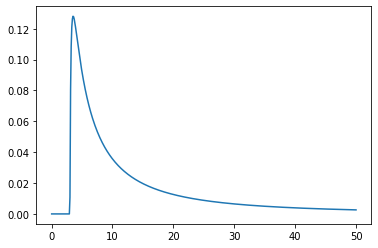

In [74]:
import scipy.stats

x=np.linspace(0.01,50,500)
m=7.0
s=1.6
t=3.0

lnorm=scipy.stats.lognorm.pdf(x,s,t,m)

lognorm=np.exp(-(np.log((x-t)/m))**2/(2*s**2))/((x-t)*s*np.sqrt(2*np.pi))
where_are_NaNs = np.isnan(lognorm)
lognorm[where_are_NaNs] = 0.0
print(np.std(lognorm))
plt.plot(x,lognorm)

In [75]:
with pm.Model() as model:
    mval = pm.Uniform('mval',lower=0.0,upper=10.0)#pm.Bound(pm.Normal, lower=0.0, upper=20.0)('mval', mu=5.0, sigma=10.0)##
    sval = pm.Uniform('sval',lower=0.0,upper=4.0)#pm.Bound(pm.Normal, lower=0.0, upper=5.0)('sval',mu=2.0,sigma=2.0)
    tval = pm.Uniform('tval',lower=0.0,upper=10.0)#pm.Bound(pm.Normal, lower=0.0, upper=10.0)('tval', mu=5.0, sigma=5.0)
    
    #sigma=pm.Normal('sigma',mu=1.0,sigma=1.0)
    LN = np.exp(-(np.log((x-tval)/mval))**2/(2*sval**2))/((x-tval)*sval*np.sqrt(2*np.pi))
    LN = tt.switch(tt.isnan(LN), 0.0, LN)
    
    y_ = pm.Normal("y", mu=LN, sigma=np.std(lognorm) ,observed=lognorm)

    trace = pm.sample(5000,tune=5000,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tval, sval, mval]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:26<00:00, 1512.70draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6753478687639206, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\Malte\Anaconda3\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mval,7.136395,0.548692,0.006658,6.085311,8.203534,6547.992230,0.999915
sval,1.612160,0.075593,0.000875,1.469323,1.765826,7060.994347,1.000056
tval,3.007535,0.044687,0.000457,2.920838,3.090593,7553.328646,1.000524


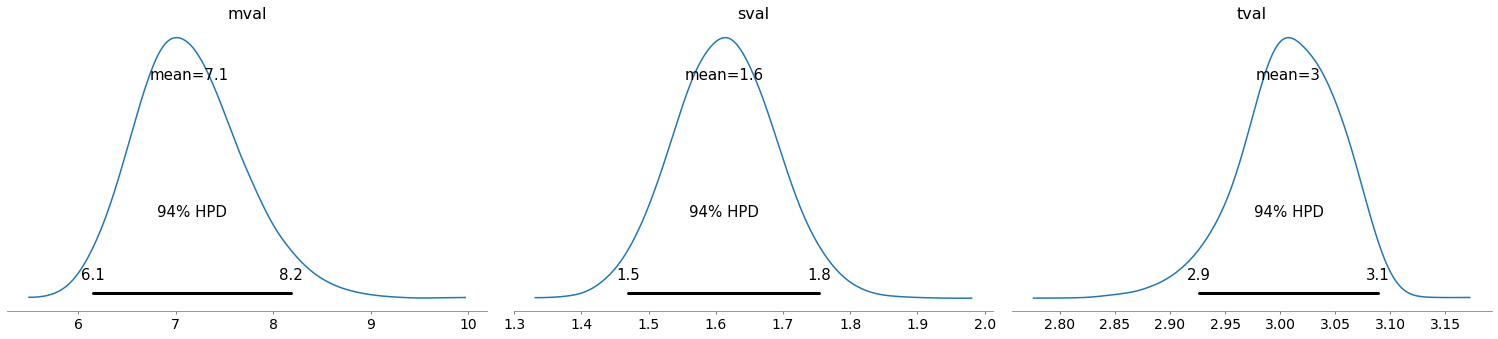

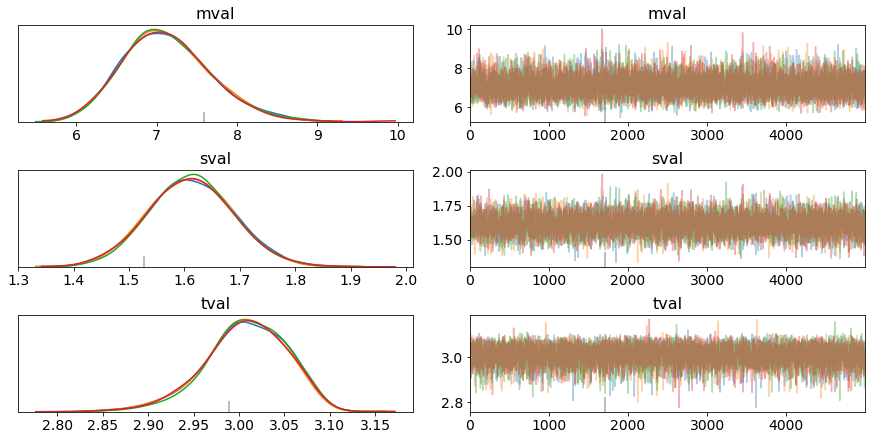

In [76]:
pm.plot_posterior(trace)
pm.traceplot(trace)
pm.summary(trace)

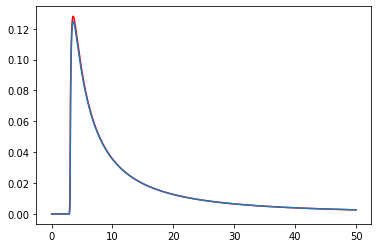

In [78]:
mval=np.mean(trace['mval'])
sval=np.mean(trace['sval'])
tval=np.mean(trace['tval'])

LNNew = np.exp(-(np.log((x-tval)/mval))**2/(2*s**2))/((x-tval)*sval*np.sqrt(2*np.pi))
where_are_NaNsLN = np.isnan(LNNew)
LNNew[where_are_NaNsLN] = 0.0

plt.plot(x,lognorm,'r')
plt.plot(x,LNNew)

In [79]:
ppc = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 20000/20000 [00:16<00:00, 1245.57it/s]


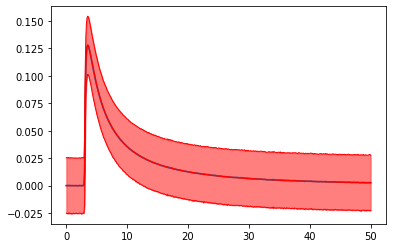

In [80]:

#plt.plot(x,ppc['y'])
#print(ppc['y'].size)
mu = np.zeros(len(x))
sd = np.zeros(len(x))

for i in range(0,len(x)):
    mu[i] = np.mean(ppc['y'][:,i])
    sd[i] = np.std(ppc['y'][:,i])


plt.plot(x,mu)
#plt.plot(x,ppc['y'][-1,:])
plt.plot(x,lognorm,'r')
plt.plot(x, mu + sd, 'r', lw=1); plt.plot(x, mu - sd, 'r', lw=1);
plt.fill_between(x.flatten(), mu - sd, mu + sd, color="r", alpha=0.5)